In [ ]:
import requests
from bs4 import BeautifulSoup
from lxml import html
import pandas as pd
import pickle
import re
import os
import urllib.request


url = 'https://syllabus.naist.jp/subjects/preview_list'
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')

lxml = html.fromstring(str(soup))

title = []
url = []

#授業名(title)とシラバスの授業ページへのurl(url)
title.append(lxml.xpath('//td[@class="w20pr"]/a/text()'))
url.append(lxml.xpath('//td[@class="w20pr"]/a/@href'))

head = 'https://syllabus.naist.jp/'

#'教育目的'と'授業概要'があるのでそれぞれpurpose, conceptとして集める
purpose = []
concept = []
for i in range(len(title[0])):
    res2 = requests.get(head + url[0][i])
    soup2 = BeautifulSoup(res2.text, 'html.parser')
    lxml2 = html.fromstring(str(soup2))



    purpose.append(lxml2.xpath('//th[text()="教育目的／授業目標"]/following-sibling::td[1]/text()')[0])
    concept.append(lxml2.xpath('//th[text()="授業概要／指導方針"]/following-sibling::td[1]/text()')[0])
    
df = pd.DataFrame({'授業名': title[0], 'シラバスURL':url[0], '教育目的': purpose, '授業概要': concept})

df['uni'] = df['教育目的'] + df['授業概要']
#今回は日本語シラバスのみを対象にしたいので、英語で書かれているなどのシラバスは削除
df.drop(df.index[[0,4,10,11,12,13,14,16,67,110]], inplace=True)
df = df.reset_index(drop=True)

In [78]:

with open('data.pickle', 'rb') as f:
    df = pickle.load(f)


In [79]:

from janome.tokenizer import Tokenizer
t = Tokenizer()

def tokenizer(text):
    text = re.sub('\d+', '', text)
    return [tok for tok in t.tokenize(text, wakati=True)]

    
df['wakati'] = df['uni'].apply(tokenizer)

In [81]:

def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

#option:ストップワード以外の不要な文字
option = ['(', ')', '（', '）', ',', '、', '。', '／', '/', '：', ':', '[', ']', '・', '.', '（']
stop_words = stop_words + option

#数字、アルファベットを削除

#分かち書きしたテキストに対してストップワードを削除
def stopwords(wakati):
    return [t for t in wakati if t not in stop_words]


#前処理
df['wakati'] = df['wakati'].apply(stopwords)



File already exists.


In [90]:
#分かち書きしたシラバスからDoc2Vecで分散表現を得る
#Kmeansでクラスタリングするときに次元数が多いと距離関係を有効に使えなさそうなので、PCAで次元削減する。
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA
model = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")

df['vec'] = df['wakati'].apply(model.infer_vector)
pca = PCA(n_components=2)

data_pca= pca.fit_transform(df['vec'].values.tolist())



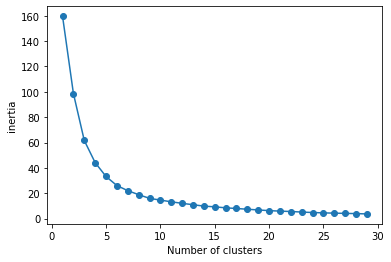

In [112]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []

for i  in range(1,30):               
    km = KMeans(n_clusters=i,
                init='k-means++', 
                n_init=10,
                max_iter=300,
                random_state=2020)
    km.fit(data_pca)
    distortions.append(km.inertia_)

plt.plot(range(1,30),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()


In [ ]:
n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters, verbose=1, random_state=2020, n_jobs=-1, max_iter = 500)

kmeans_model.fit(data_pca)
label = kmeans_model.labels_
df['kmeans'] = label

In [95]:
#wordcloudで使う名詞リストの準備

def extract_noun(text):
    nouns = []
    tokened = stopwords(t.tokenize(text))
    for token in t.tokenize(text):
        part_of_speech = token.part_of_speech.split(',')[0]
        if part_of_speech == u'名詞':
            word = token.surface
            nouns.append(word)
    return nouns

df['noun'] = df['uni'].apply(extract_noun)
df['noun'] = df['noun'].apply(stopwords)

In [111]:
from wordcloud import WordCloud



def text_for_wordcloud(data, idx):

    text = []
    Series = data[data['kmeans'] == idx]['noun']
    for col in Series:
        text += col
    
    text = ' '.join(text)
    
    fpath = "~/Library/Fonts/Arial Unicode.ttf"
    wc = WordCloud(width=480, height=320, font_path = fpath)
    wc.generate(text)
    wc.to_file("wordcloud%s.png" % idx)
    


for i in range(5):
    text_for_wordcloud(df, i)


In [115]:
df.head(10)

,授業名,シラバスURL,教育目的,授業概要,uni,wakati,noun,vec,kmeans
0,科学哲学,/subjects/preview_detail/402,科学技術の性質・方法・変化、さらにはそれを取り巻く社会的問題について理解を深め、科学技術全体...,この講義では広い意味での科学哲学（科学史，科学技術社会論などを含む）について扱う。科学技術の...,科学技術の性質方法変化、さらにはそれを取り巻く社会的問題について理解を深め、科学技術全体につ...,"[科学, 技術, の, 性質, 変化, さらに, は, を, 取り巻く, 社会, 問題, に...","[科学, 技術, 性質, 変化, 社会, 問題, 理解, 科学, 技術, 全体, 俯瞰, 目...","[0.3678862, 0.34637618, 0.36689, 0.18304126, -...",1
1,科学コミュニケーション,/subjects/preview_detail/403,1．科学者・技術者として活躍するために、異分野の専門家と情報を共有し、議論できる能力を養う。,様々なバックグラウンドを有する学生が参加してインタラクティブな授業をおこなう。,．科学者技術者として活躍するために、異分野の専門家と情報を共有し、議論できる能力を養う。様々...,"[．, 科学, 技術, として, 活躍, する, に, 異, 分野, の, 専門, と, 情...","[科学, 技術, 活躍, 分野, 専門, 情報, 共有, 議論, 能力, バックグラウンド,...","[0.25031748, 0.07903225, 0.07907591, 0.0789593...",2
2,知的財産権,/subjects/preview_detail/404,研究者、技術者にとって今後ますます不可欠となる知的財産権の重要性とその概略について理解するこ...,この講義では、特許要件、特許出願からその利用、著作権その他について知的財産権の基礎的、実践的...,研究者、技術者にとって今後ますます不可欠となる知的財産権の重要性とその概略について理解するこ...,"[研究, 技術, にとって, 今後, ますます, 不可欠, と, なる, 知的, 財産, 権...","[研究, 技術, 今後, 不可欠, 知的, 財産, 権, 重要, 概略, 理解, 目的, 講...","[0.2107917, -0.0341199, 0.2944229, 0.13721964,...",1
3,イノベーション創出特論Ⅰ,/subjects/preview_detail/405,イノベーション創出につながる先端科学技術の事業化に必要な起業家マインド、事業化ノウハウ、課題...,世界的な交通・情報インフラの向上による国際化の伸展や、ビッグデータ活用、AI技術、IoTの普...,イノベーション創出につながる先端科学技術の事業化に必要な起業家マインド、事業化ノウハウ、課題...,"[イノベーション, 創出, に, つながる, 先端, 科学, 技術, の, 事業, に, 必...","[イノベーション, 創出, 先端, 科学, 技術, 事業, 必要, 起業, マインド, 事業...","[0.51833, -0.12120126, 0.2599643, 0.16197084, ...",0
4,イノベーション創出特論Ⅱ,/subjects/preview_detail/406,グローバルアントレプレナーが事業を推進するために必須となるビジネスプラン案を見る力、作る力、...,世界的な交通・情報インフラの向上による国際化の伸展や、ビッグデータ活用、AI技術、IoTの普...,グローバルアントレプレナーが事業を推進するために必須となるビジネスプラン案を見る力、作る力、...,"[グローバルアントレプレナー, が, 事業, を, 推進, する, に, 必須, と, なる...","[グローバルアントレプレナー, 事業, 推進, 必須, ビジネス, プラン, 案, 修正, ...","[0.5425016, -0.16634305, 0.28234035, 0.0735468...",0
5,イノベーション創出特論Ⅲ,/subjects/preview_detail/407,イノベーション創出につながる先端科学技術の事業化を行うために必要な事業実施能力を涵養する。グ...,世界的な交通・情報インフラの向上による国際化の伸展や、ビッグデータ活用、AI技術、IoTの普...,イノベーション創出につながる先端科学技術の事業化を行うために必要な事業実施能力を涵養する。グ...,"[イノベーション, 創出, に, つながる, 先端, 科学, 技術, の, 事業, を, 行...","[イノベーション, 創出, 先端, 科学, 技術, 事業, 必要, 事業, 実施, 能力, ...","[0.547296, -0.02227514, 0.14659499, 0.30901068...",0
6,イノベーション創出特論Ⅳ,/subjects/preview_detail/408,イノベーション創出につながる先端科学技術の事業化を行うために必要な事業実施能力を涵養する。グ...,世界的な交通・情報インフラの向上による国際化の伸展や、ビッグデータ活用、AI技術、IoTの普...,イノベーション創出につながる先端科学技術の事業化を行うために必要な事業実施能力を涵養する。グ...,"[イノベーション, 創出, に, つながる, 先端, 科学, 技術, の, 事業, を, 行...","[イノベーション, 創出, 先端, 科学, 技術, 事業, 必要, 事業, 実施, 能力, ...","[0.571768, -0.08443156, 0.19770466, 0.24608651...",0
7,イノベーション創出特論Ⅴ,/subjects/preview_detail/409,グローバルアントレプレナーが事業を推進するために必須となるビジネスプラン案を見る力、作る力、...,世界的な交通・情報インフラの向上による国際化の伸展や、ビッグデータ活用、AI技術、IoTの普...,グローバルアントレプレナーが事業を推進するために必須となるビジネスプラン案を見る力、作る力、...,"[グローバルアントレプレナー, が, 事業, を, 推進, する, に, 必須, と, なる...","[グローバルアントレプレナー, 事業, 推進, 必須, ビジネス, プラン, 案, 修正, ...","[0.56568885, -0.2573136, 0.23782858, 0.1390485...",0
8,アドバンスドリサーチライティング,/subjects/preview_detail/415,本コースでは、インパクトファクターの高い学術雑誌への投稿に必要な英文ライティングの知識とスキ...,ライティング・ディスカッションへの積極的参加が求められます。,本コースでは、インパクトファクターの高い学術雑誌への投稿に必要な英文ライティングの知識とスキ...,"[本, コース, で, は, インパクト, ファクター, の, 高い, 学術, 雑誌, へ,...","[コース, インパクト, ファクター, 学術, 雑誌, 投稿, 必要, 英文, ライティング...","[0.20413093, 0.15778984, 0.07944878, 0.0896022...",2
9,日本語Ⅰ,/subjects/preview_detail/598,1.簡単に自分のこと（名前・国・趣味など）を話したり相手のことを聞いたりすることができる。,学習者主体の考えに基づき初級に必要な語彙・文法を導入しながら、日本語で人とつながる力を養成す...,.簡単に自分のこと（名前国趣味など）を話したり相手のことを聞いたりすることができる。学習者主...,"[簡単, に, の, 趣味, を, 話し, たり, 相手, の, を, 聞い, たり, する...","[簡単, 趣味, 相手, 学習, 主体, 考え, 初級, 必要, 語彙, 文法, 導入, 日...","[0.22516906, 0.16755903, -0.11926458, 0.160542...",2
